This script test the impact of using different types of spectral constraints to estimate the desired graph. Graphs are generated as grid graphs where each node has 4 neighbors except those nodes on the borders. The error of the recovered graph is computed as the number of samples increases.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import src.utils as utils

# %matplotlib qt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)
DATASET_PATH = 'data/student_networks/'

## Considered constraints

In [2]:
GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

## Auxiliary functions

In [3]:
def est_graph(id, models, MM, L, iters):
    X = utils.create_signals(L, MM[-1])

    N = X.shape[0]
    L_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i,M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()
            L_hat[:,:,j,i], lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters) 
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {} - Time(sec): {:.3}'.format(id, M, model['name'], t))
    return L_hat, lamd_hat


def est_errs1(L, lamd, L_hat, lams_hat, sq_err=True):
    norm_L = np.linalg.norm(L, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)
    
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                err_L[j,i,k] = np.linalg.norm(L-L_hat[:,:,j,i,k], 'fro')/norm_L
                err_lamb[j,i,k] = np.linalg.norm(lamd-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def est_errs2(L, lamd, L_hat, lams_hat, sq_err=True):
    norm_L = np.linalg.norm(L, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)
    
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                if np.all((L_hat[:,:,j,i,k] == 0)):
                    norm_L_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_L_hat = np.linalg.norm(L_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                L_hat_norm = L_hat[:,:,j,i,k]/norm_L_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def plot_err(MM, models, err, ylab, logy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if logy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                         linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('M')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


## Using graphs 10 and 8 

### Read graphs

	c-0: c: 3.625	c0: 3.500	err: 0.125000	err norm: 0.035714
	c-1: c: 18.438	c0: 17.562	err: 0.875000	err norm: 0.049822
	c-2: c: 0.142	c0: 0.140	err: 0.001805	err norm: 0.012914
	c-3: c: 1.891	c0: 1.766	err: 0.125000	err norm: 0.070796


Text(0.5, 1.0, 'True Lambdas, N: 32')

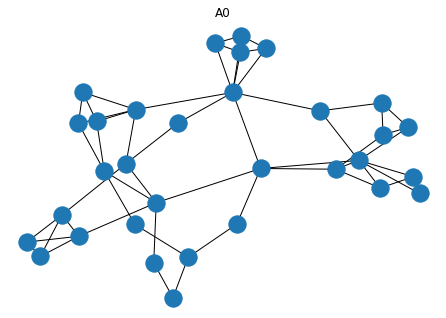

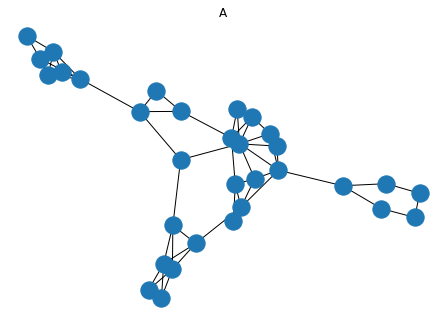

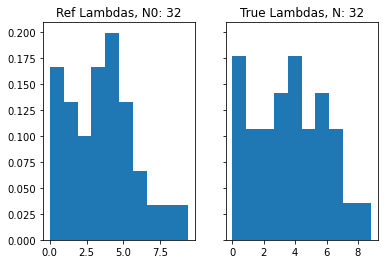

In [4]:
graphs_idx = [10,8]
As = utils.get_student_networks_graphs(graphs_idx, DATASET_PATH)
A0 = As[:,:,0]
N0 = A0.shape[0]
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)

A = As[:,:,1]
N = A.shape[0]
L = np.diag(np.sum(A, 0)) - A
lambdas, _ = np.linalg.eigh(L)

cs, _ = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

plt.figure()
nx.draw(nx.from_numpy_matrix(A0))
plt.title('A0')
plt.figure()
nx.draw(nx.from_numpy_matrix(A))
plt.title('A')

figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

### Experiment parameters

In [5]:
n_covs = 50
MM = np.arange(50, 401, 50)  #np.arange(50, 401, 25)
iters = 100  #200

deltas = [.13, .88, .002, .13]

# regs for 100 iters - M=200
models = [
    # Baselines
    {'name': 'GLasso', 'alpha': 0.05, 'fmt': '^--'},
    {'name': 'Tr=N', 'cs': 1, 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 0, 'deltas': 1e-4}},
    {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': .001, 'beta': 2, 
     'c1': .01, 'c2': 10, 'conn_comp': 1}},
    {'name': 'Unc', 'cs': [], 'gs': [], 'bounds': [], 'fmt': 'v-',
     'regs': {'alpha': .001, 'beta': 2, 'gamma': 0, 'deltas': []}},

    # Our algorithms
    {'name': 'MGL-Tr', 'cs': cs[0], 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1.6, 'gamma': 0, 'deltas': deltas[0]}},
    # {'name': 'MGL-Sq', 'cs': cs[1], 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
    #  'regs': {'alpha': 0, 'beta': .9, 'gamma': 10000, 'deltas': deltas[1]}},
    # {'name': 'MGL-Heat', 'cs': cs[2], 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
    #  'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 5000, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'cs': cs[3], 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 1000, 'deltas': deltas[3]}},
]

# regs for 200 iters - M=200
models = [
    # Baselines
    {'name': 'GLasso', 'alpha': 0.05, 'fmt': '^--'},
    {'name': 'Tr=N', 'cs': 1, 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1.6, 'gamma': 0, 'deltas': 1e-4}},
    {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': .001, 'beta': 2.5, 
     'c1': .01, 'c2': 10, 'conn_comp': 1}},
    {'name': 'Unc', 'cs': [], 'gs': [], 'bounds': [], 'fmt': 'v-',
     'regs': {'alpha': .001, 'beta': 2.5, 'gamma': 0, 'deltas': []}},

    # Our algorithms
    {'name': 'MGL-Tr', 'cs': cs[0], 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 2.4, 'gamma': 0, 'deltas': deltas[0]}},
    # {'name': 'MGL-Sq', 'cs': cs[1], 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
    #  'regs': {'alpha': 0, 'beta': .9, 'gamma': 10000, 'deltas': deltas[1]}},
    # {'name': 'MGL-Heat', 'cs': cs[2], 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
    #  'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 5000, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'cs': cs[3], 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 2.1, 'gamma': 5000, 'deltas': deltas[3]}},
]


# # regs for 200 iters
# models = [
#     # Baselines
#     {'name': 'GLasso', 'alpha': 0.1, 'fmt': '^--'},
#     {'name': 'GLasso', 'alpha': 0.05, 'fmt': '^--'},
#     {'name': 'GLasso', 'alpha': 0.03, 'fmt': '^--'},


#     {'name': 'Tr=N', 'cs': 1, 'gs': GS[0], 'bounds': [], 'fmt': '2--',
#      'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 0, 'deltas': 1e-4}},
#     {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': 0, 'beta': 1.5, 
#      'c1': .01, 'c2': 10, 'conn_comp': 1}},
#     {'name': 'Unc', 'cs': [], 'gs': [], 'bounds': [], 'fmt': 'v-',
#      'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 0, 'deltas': []}},

#     # Our algorithms
#     {'name': 'MGL-Tr', 'cs': cs[0], 'gs': GS[0], 'bounds': [], 'fmt': '2-',
#      'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 0, 'deltas': deltas[0]}},
#     {'name': 'MGL-Sq', 'cs': cs[1], 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
#      'regs': {'alpha': 0, 'beta': .9, 'gamma': 10000, 'deltas': deltas[1]}},
#     # {'name': 'MGL-Heat', 'cs': cs[2], 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
#     #  'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 5000, 'deltas': deltas[2]}},
#     {'name': 'MGL-Poly', 'cs': cs[3], 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
#      'regs': {'alpha': 0, 'beta': .9, 'gamma': 10000, 'deltas': deltas[3]}},
# ]

# regs for 100 iters
# models = [
#     # Baselines
#     # {'name': 'GLasso', 'alpha': 0.05, 'fmt': '^--'},
#     # {'name': 'GLasso', 'alpha': 0.03, 'fmt': '^--'},
#     {'name': 'MGL-Tr=1', 'cs': 1, 'gs': GS[0], 'bounds': [], 'fmt': '2--',
#      'regs': {'alpha': 0, 'beta': .9, 'gamma': 0, 'deltas': 1e-4}},
#     {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': 0, 'beta': 1.5, 'c1': .01, 'c2': 10, 'conn_comp': 1}},
#     {'name': 'Unc', 'cs': [], 'gs': [], 'bounds': [], 'fmt': 'v-',
#      'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 0, 'deltas': []}},

#     # Our algorithms
#     {'name': 'MGL-Tr', 'cs': cs[0], 'gs': GS[0], 'bounds': [], 'fmt': '2-',
#      'regs': {'alpha': 0, 'beta': .7, 'gamma': 0, 'deltas': deltas[0]}},
#     # {'name': 'MGL-Sq', 'cs': cs[1], 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
#     #  'regs': {'alpha': 0, 'beta': .9, 'gamma': 10000, 'deltas': deltas[1]}},
#     # {'name': 'MGL-Heat', 'cs': cs[2], 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
#     #  'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 5000, 'deltas': deltas[2]}},
#     {'name': 'MGL-Poly', 'cs': cs[3], 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
#      'regs': {'alpha': 0, 'beta': .9, 'gamma': 10000, 'deltas': deltas[3]}},
# ]

### Run and plot experiment

In [6]:
# Estimate graph
total_t = time.time()
Ls_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, iters) for i in range(n_covs))
for i, resp in enumerate(resps):
    Ls_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 31.09143037398656  mins -----


In [13]:
err_L, err_lamb = est_errs2(L, lambdas, Ls_hat, lamds_hat, sq_err=True)
mean_errL = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_errL, 'Mean Err2 L')
plot_err(MM, models, mean_err_lam, 'Mean Err2 lambdas')

In [15]:
# Plot error 1
err_L, err_lamb = est_errs1(L, lambdas, Ls_hat, lamds_hat)
mean_errL = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_errL, 'Mean Err1 L')


In [10]:
# Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models]

# data = {
#     'L': L,
#     'lambdas': lambdas,
#     'Ls_hat': Ls_hat,
#     'lamds_hat': lamds_hat,
#     'MM': MM,
#     'models': models_aux
# }
# file = 'students_{}covs_{}iters_graphs{}-{}'.format(n_covs, iters,
#     graphs_idx[0], graphs_idx[1])
# np.save('results/student_network/' + file, data)

In [11]:
# Load data
# %matplotlib qt
# file = 'results/constraints/constraints_50covs_50iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# L = data['L']
# lambdas = data['lambdas']
# Ls_hat = data['Ls_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']

## Using graphs 9 and 7

### Read graphs

In [23]:
graphs_idx = [9,7]
As = utils.get_student_networks_graphs(graphs_idx, DATASET_PATH)
A0 = As[:,:,0]
N0 = A0.shape[0]
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)

A = As[:,:,1]
N = A.shape[0]
L = np.diag(np.sum(A, 0)) - A
lambdas, _ = np.linalg.eigh(L)

cs, _ = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

plt.figure()
nx.draw(nx..from_numpy_matrix(A0))
plt.title('A0')
plt.figure()
nx.draw(nx..from_numpy_matrix(A))
plt.title('A')

figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

	c-0: c: 2.562	c0: 2.500	err: 0.062500	err norm: 0.025000
	c-1: c: 10.312	c0: 9.812	err: 0.500000	err norm: 0.050955
	c-2: c: 0.244	c0: 0.252	err: -0.007925	err norm: -0.031491
	c-3: c: 0.656	c0: 0.578	err: 0.078125	err norm: 0.135135


Text(0.5, 1.0, 'True Lambdas, N: 32')

### Experiment parameters

In [10]:
n_covs = 50
MM = np.arange(50, 401, 25)
iters = 200

deltas = [.03, .88, .002, .08]
models = [
    # Baselines
    # {'name': 'GLasso', 'alpha': 0.05, 'fmt': '^--'},
    # {'name': 'GLasso', 'alpha': 0.03, 'fmt': '^--'},
    {'name': 'MGL-Tr=1', 'cs': 1, 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 0, 'deltas': 1e-4}},
    {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': 0, 'beta': 1.5, 'c1': .1, 'c2': 8, 'conn_comp': 3}},
    {'name': 'Unc', 'cs': [], 'gs': [], 'bounds': [], 'fmt': 'v-',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 0, 'deltas': []}},

    # Our algorithms
    {'name': 'MGL-Tr', 'cs': cs[0], 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 0, 'deltas': deltas[0]}},
    {'name': 'MGL-Sq', 'cs': cs[1], 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 1000, 'deltas': deltas[1]}},
    # {'name': 'MGL-Heat', 'cs': cs[2], 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
    #  'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 5000, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'cs': cs[3], 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 5000, 'deltas': deltas[3]}},
]

### Run and plot experiment

In [11]:
# Estimate graph
total_t = time.time()
Ls_hat2 = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat2 = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, iters) for i in range(n_covs))
for i, resp in enumerate(resps):
    Ls_hat2[:,:,:,:,i], lamds_hat2[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 30.087665303548178  mins -----


In [22]:
err_L, err_lamb = est_errs2(L, lambdas, Ls_hat2, lamds_hat2, sq_err=True)
mean_errL = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_errL, 'Mean Err2 L')
plot_err(MM, models, mean_err_lam, 'Mean Err2 lambdas')

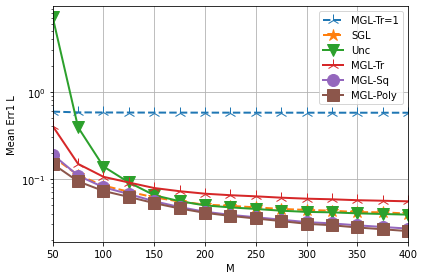

In [13]:
# Plot error 1
err_L, err_lamb = est_errs1(L, lambdas, Ls_hat2, lamds_hat2)
mean_errL = np.mean(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(MM, models, mean_errL, 'Mean Err1 L')


In [14]:
# # Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models]

# data = {
#     'L': L,
#     'lambdas': lambdas,
#     'Ls_hat2': Ls_hat2,
#     'lamds_hat2': lamds_hat2,
#     'MM': MM,
#     'models': models_aux
# }
# file = 'students_{}covs_{}iters_graphs{}-{}'.format(n_covs, iters,
#     graphs_idx[0], graphs_idx[1])
# np.save('results/student_network/' + file, data)

In [15]:
# Load data
# %matplotlib qt
# file = 'results/constraints/constraints_50covs_50iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# L = data['L']
# lambdas = data['lambdas']
# Ls_hat2 = data['Ls_hat2']
# lamds_hat2 = data['lamds_hat2']
# MM = data['MM']
# models = data['models']